In [40]:
# import YOLOP dependencies
import sys
sys.path.append('/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/YOLOP')
from lib.utils.utils import select_device
from lib.config import cfg
from lib.models import get_net
from pathlib import Path

# import clustering method
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics
from tqdm.notebook import tqdm
from PIL import Image

# import torch, cv2 and other dependencies
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet101

import os
import cv2
import pickle
import logging
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import math

In [3]:
# set random seed
import random
random.seed(33)
np.random.seed(33)

# Create BDD100k dataset loader

In [25]:
class BDD100kDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataroot,
        image_set="train",
        transform=transforms.Compose([transforms.Resize((384, 384)), 
                                      transforms.ToTensor(),
                                      transforms.Normalize(0.5, 0.5),
                                      ]),
        is_test=False,
        keep_difficult=False,
        label_file=None,
        version='100k',
        split='train'
    ):
        """Dataset for BDD100k data.
        Args:
            dataroot: the root of the BDD100k dataset, 
        """
        self.dataroot = dataroot
        self.transform = transform
        self.version = version
        self.split = split
        self.filenames, self.tokens = [], []
        
        if self.version in ['10k', '100k']: 
            self.dataroot = os.path.join(self.dataroot, self.version, self.split)
        else:
            assert self.version in ['10k','100k']
            print('Please use either 10k samples version or 100k full dataset')
        
        #pbar = tqdm(enumerate(os.listdir(self.dataroot)))
        #for filename in os.listdir(self.data_dir):
        img_list = os.listdir(self.dataroot)
        for idx, filename in enumerate(tqdm(img_list)):
            img_path = os.path.join(self.dataroot, filename)
            self.filenames.append(img_path)
            self.tokens.append(idx)
            
        print('Number of data samples in the set: {}'.format(len(self.filenames)))

    # method to get length of data
    def __len__(self):
        return len(self.filenames)

    # method to get a sample
    def __getitem__(self, idx):
        # get image
        image_filename = self.filenames[idx]
        image = Image.open(image_filename).convert('RGB')
        # transform image
        image = self.transform(image)
        # get token
        token = self.tokens[idx]
        # return image
        return {'image': image, 'token': token}


In [51]:
dataset = BDD100kDataset(dataroot='/s/dat/UserFolders/xzhan258/LaneDetection/BDD100K/bdd100k_images/bdd100k/images', 
                         version='100k', 
                         split='train')

  0%|          | 0/48156 [00:00<?, ?it/s]

Number of data samples in the set: 48156


# Define paths and dataset

In [52]:
DEV_ROOT = '/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/YOLOP'
dataset_str='bdd100k'
train_features_fname = os.path.join(DEV_ROOT, f'{dataset_str}_training_features_50k.pkl')
train_cluster_info_fname = os.path.join(DEV_ROOT, f'{dataset_str}_training_cluster_info_50k.pkl')

In [53]:
print(train_features_fname)

/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/YOLOP/bdd100k_training_features_50k.pkl


# Compute features from raw dataset

## option #1 load torch pretrained models

In [ ]:
if not os.path.exists(train_features_fname):
    # use a pre-trained model to get the feature vectors for all the images
    # in the dataset
    model = resnet101(pretrained=True, progress=True)
    # remove the last layer keeping the weights
    model = torch.nn.Sequential(*list(model.children())[:-1])

    model.eval()
    model.cuda()
    train_tokens, train_features = [], []
    with torch.no_grad():
        for i in tqdm(range(len(dataset))):
            img = dataset[i]['image'].unsqueeze(0).cuda()
            # inference
            feature = model(img).flatten().cpu().numpy()
            train_features.append(feature)
            train_tokens.append(dataset[i]['token'])
    train_features = np.array(train_features)
    # save the features to disk as a pickle file
    with open(train_features_fname, 'wb') as f:
        pickle.dump({'tokens': train_tokens, 'features': train_features}, f)

  0%|          | 0/48156 [00:00<?, ?it/s]

## option #2 load other models

In [ ]:
def yolop(pretrained=True, device="cpu"):
    """Creates YOLOP model
    Arguments:
        pretrained (bool): load pretrained weights into the model
        wieghts (int): the url of pretrained weights
        device (str): cuda device i.e. 0 or 0,1,2,3 or cpu
    Returns:
        YOLOP pytorch model
    """
    device = select_device(device = device)
    model = get_net(cfg)
    if pretrained:
        path = '/s/dat/UserFolders/xzhan258/private_dev/DatasetEquity/YOLOP/weights/End-to-end.pth'
        checkpoint = torch.load(path, map_location= device)
        model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)
    return model

# could also load other pretrained model
# model = yolop(pretrained=True, device="cpu")
# model.gr = 1.0
# model.nc = 1

# Compute clusters in a lower-dimensional space for training dataset

Projecting training dataset features to 2D...
[t-SNE] Computing 160 nearest neighbors...
[t-SNE] Indexed 2838 samples in 0.006s...


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 2838 samples in 0.393s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2838
[t-SNE] Computed conditional probabilities for sample 2000 / 2838
[t-SNE] Computed conditional probabilities for sample 2838 / 2838
[t-SNE] Mean sigma: 2.529650
[t-SNE] Computed conditional probabilities in 0.132s
[t-SNE] Iteration 50: error = 73.3246536, gradient norm = 0.0000006 (50 iterations in 0.665s)
[t-SNE] Iteration 100: error = 73.3246460, gradient norm = 0.0000000 (50 iterations in 0.648s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 73.324646
[t-SNE] Iteration 150: error = 3.6254900, gradient norm = 0.0000003 (50 iterations in 0.453s)
[t-SNE] Iteration 200: error = 3.6254892, gradient norm = 0.0000088 (50 iterations in 0.493s)
[t-SNE] Iteration 250: error = 3.6242197, gradient norm = 0.0017813 (50 iterations in 0.497s)
[t-SNE] Iteration 300: error = 3.0644279, gradient norm =

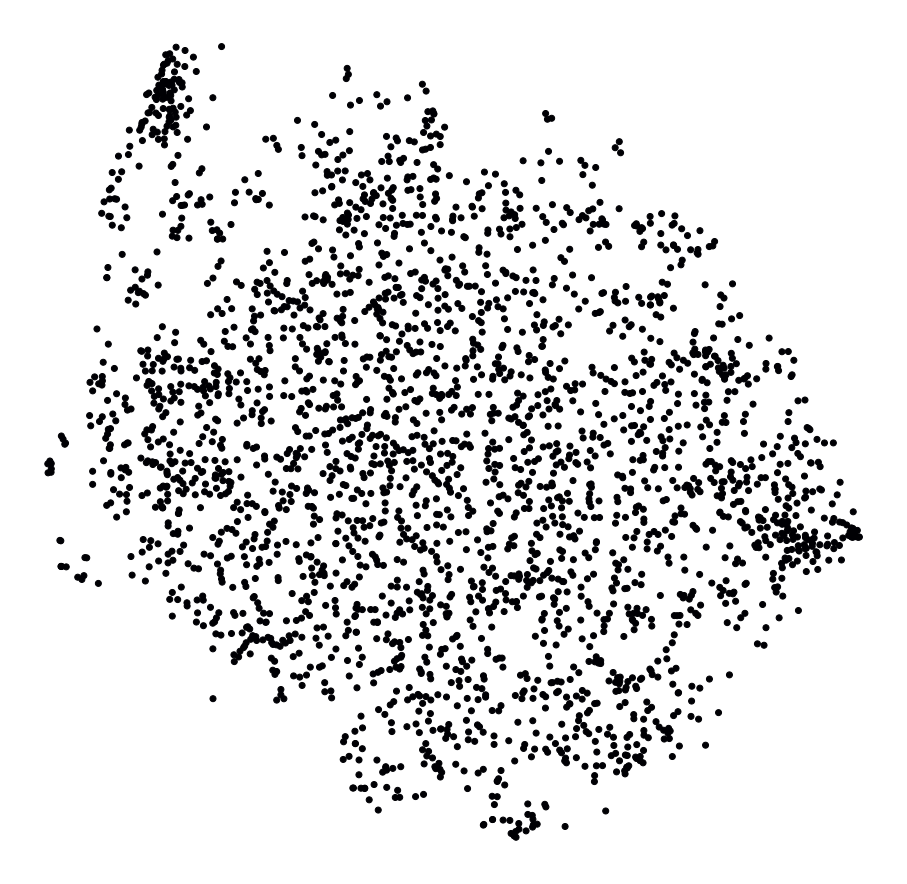

In [50]:
# load the training features from disk
data = pickle.load(open(train_features_fname, 'rb'))
train_tokens, train_features = \
    data['tokens'], data['features']

# project the features onto a 2D t-SNE plot
print('Projecting training dataset features to 2D...')

num_dimensions = 2
learning_rate= 1
num_images = 2838
verbose = 2
n_iteraions = 500
random_num = int(random.random())        

tsne = TSNE(n_components=num_dimensions, 
            learning_rate = learning_rate,
            perplexity=round(math.sqrt(num_images)),
            random_state = random_num,
            verbose=verbose, 
            n_iter=n_iteraions)
tsne_results = tsne.fit_transform(train_features)
# find clusters using DBSCAN

db = DBSCAN(eps=0.05 , min_samples=15).fit(tsne_results)
print('Number of clusters: {}'.format(len(np.unique(db.labels_))))
labels = db.labels_

# visualize the clusters
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=labels, cmap='inferno')
ax.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='inferno')
plt.axis('off')

plt.savefig(os.path.join(DEV_ROOT, f'{dataset_str}_training_clusters_50k.png'), bbox_inches='tight', pad_inches=0)
plt.show()